In [ ]:
# Time Series Methods 

In [ ]:
# Keywords
time series, univariate

In [ ]:
# Refrences
[Time Series Methods](https://cprosenjit.medium.com/?p=291037d2e285)
[Moving Average](https://365datascience.com/tutorials/time-series-analysis-tutorials/moving-average-model/)
[Stationarity in time series](https://towardsdatascience.com/stationarity-in-time-series-analysis-90c94f27322)

In [1]:
# imports
import os

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import seaborn as sns

from sklearn.metrics import mean_squared_error
from math import sqrt

from statsmodels.tsa.api import acf, graphics, pacf
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

In [2]:
# settings
import warnings
warnings.filterwarnings('ignore')
#print all rows of a df in ipython shell 
pd.set_option('display.max_rows', None)
#print all columns of a df in ipython shell 
pd.set_option('display.max_columns', None)

# optional
pd.set_option('display.max_columns',100)
sns.set_style('darkgrid')

In [ ]:
# Overview

Time Series Types

Univariate Time Series: only one variable is varying over time.
Multivariate Time Series: multiple variables are varying over time.

Data Characteristics

After plotting the time series graph we should look for the following three characteristics and accordingly we may need to take the right measures or choose the right methods.

Trend: the values are increasing/decreasing over time.
Seasonality: periodic repeating pattern of high/low values; this can be daily/weekly/monthly/yearly etc. seasonality.
Outliers: outlier values are far away than the other values in dataset.
    
Models
Autoregressive - predict the current value from previous lags
Moving Average - predict the current value based on the past residuals 


In [3]:
# Data
# load data

# path = 'e:\PycharmProjects\TimeSeries'
path = os.path.abspath(os.getcwd())
shampoo_file = 'shampoo.csv'

path_to_shampoo_file = os.path.join(path, 'data', shampoo_file)

df = pd.read_csv(path_to_shampoo_file, parse_dates=True)
df['Month']=pd.to_datetime(df['Month'], format='%Y-%m-%d')
df['Month']= pd.date_range('1/1/2001', periods=36, freq='m')
# train, test split
total_data = df["Sales"].count()
split = (total_data * 0.90).astype(np.int32)
train = df[0:split] 
test = df[split:]
#train['Month']=pd.to_datetime(train['Month'], format='%Y-%m-%d')
#test['Month']=pd.to_datetime(test['Month'], format=='%Y-%m-%d')

train = train.set_index('Month')
train.columns =['Sales']
test = test.set_index('Month')
test.columns =['Sales']
df = df.set_index('Month')


In [150]:
test

,Sales
Month,
2003-09-01,682.0
2003-10-01,475.3
2003-11-01,581.3
2003-12-01,646.9


In [6]:
len(df)

36

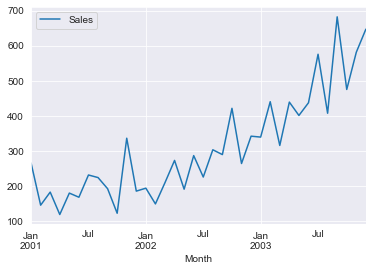

In [152]:
# plot original time series
df.plot()

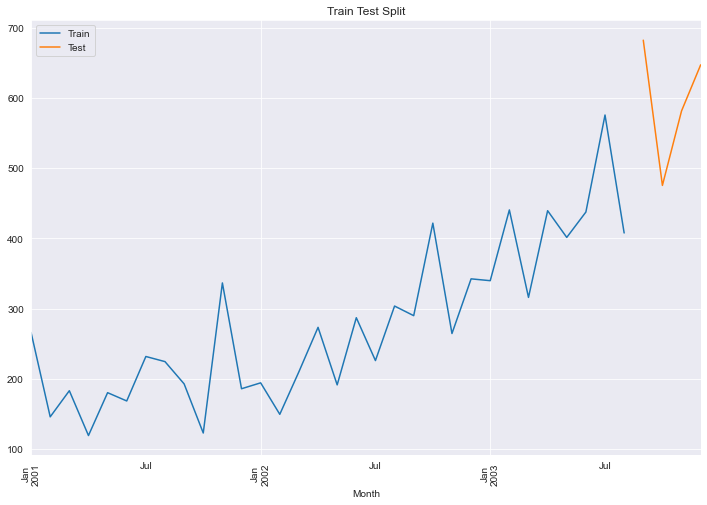

In [4]:
# plot train test time series

plt.figure(figsize=(12,8))
train.Sales.plot( label='Train')
test.Sales.plot(label='Test')
plt.xticks(rotation='vertical')
plt.legend(loc='best')
plt.title("Train Test Split")

plt.show()

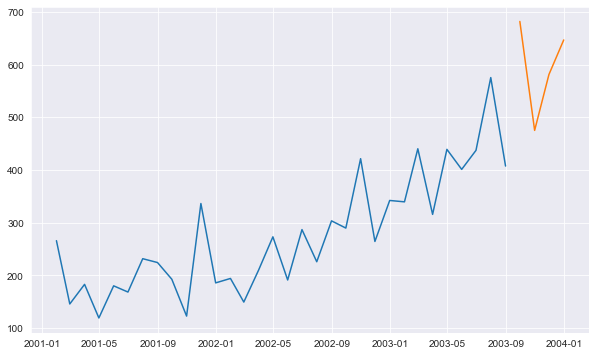

In [5]:
# plot train test using formatter

fig, ax = plt.subplots(figsize=(10, 6))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
#ax.bar(df.index, df['Sales'], width=25, align='center')
ax.plot(train)
ax.plot(test)

In [ ]:
# Predictions

In [ ]:
# 1. AR - AutoRegressive Model

Autoregressive AR-X(p) model follows linear regression. It makes one prediction at a time and feed the output back into the model. Here, p specifies the order of the model e.g, AR(1) i.e. first-order Autoregression model. The output variable depends linearly on its previous values (called lags or orders) at previous time steps i.e. regression with self-values. The lag length must be specified when creating the model.

An autoregressive (AR) model predicts future behavior based on past behavior. It’s used for forecasting when there is some correlation between values in a time series and the values that precede and succeed them. You only use past data to model the behavior, hence the name autoregressive (the Greek prefix auto– means “self.” ). The process is basically a linear regression of the data in the current series against one or more past values in the same series. 

For example: AR(1) - the regression takes into account the previous value       
             AR(5) - the last 5 values
        

In [42]:
# 1
from statsmodels.tsa.ar_model import AutoReg

# define the model
model_ag = AutoReg(endog = train["Sales"], 
                   lags = 7, 
                   trend='c', 
                   seasonal = False,
                   exog = None,
                   hold_back = None,
                   period = None,
                   missing = 'none')
# endog: dependent variable, response variable or y (endogenous)
# exog: independent variable, explanatory variable or x (exogenous)
# lags: the no. of lags to include in the model
#       [1, 4] will only include lags 1 and 4 
#       while lags=4 will include lags 1, 2, 3, and 4
# trend: trend to include in the model
#        {‘n’, ‘c’, ‘t’, ‘ct’}
#        ‘n’ - No trend.
#        ‘c’ - Constant only.
#        ‘t’ - Time trend only.
#        ‘ct’ - Constant and time trend.
# seasonal: whether to include seasonal dummies in the model

# fit the model
fit_ag = model_ag.fit()
print("Coefficients:\n%s" % fit_ag.params)

# make the predictions
predictions = fit_ag.forecast(4)
print(predictions)
# results df
predictions.name = "Predictions"
result  = pd.concat([test, predictions], axis=1).reindex(test.index)
print (result)

# measure the performance

rmse = sqrt(mean_squared_error(test["Sales"], predictions))
print("AR - Root Mean Square Error (RMSE): %.3f" % rmse)

# summary of the model
#print(fit_ag.summary())

Coefficients:
const      -33.906470
Sales.L1    -0.319220
Sales.L2     0.212906
Sales.L3     0.189463
Sales.L4     0.505078
Sales.L5     0.496669
Sales.L6     0.170001
Sales.L7     0.112577
dtype: float64
2003-09-30    565.534614
2003-10-31    511.858913
2003-11-30    625.920549
2003-12-31    593.651232
Freq: M, dtype: float64
            Sales  Predictions
Month                         
2003-09-30  682.0   565.534614
2003-10-31  475.3   511.858913
2003-11-30  581.3   625.920549
2003-12-31  646.9   593.651232
AR - Root Mean Square Error (RMSE): 70.227


Text(0.5, 1.0, 'Predictions by AutoRegressive (AR) model')

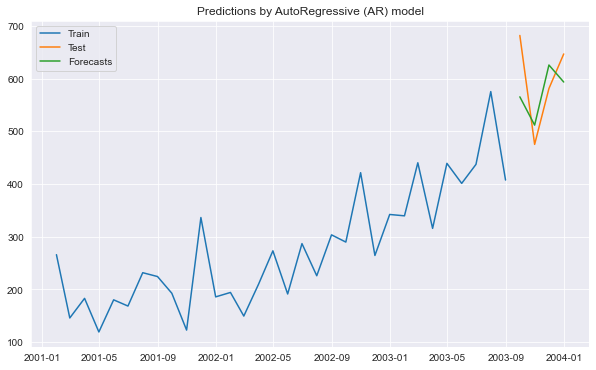

In [34]:
# plot AR train test predictions

fig, ax = plt.subplots(figsize=(10, 6))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
#ax.bar(df.index, df['Sales'], width=25, align='center')
ax.plot(train)
ax.plot(test)
ax.plot(predictions)
ax.legend( ['Train', 'Test', 'Forecasts'])
plt.title("Predictions by AutoRegressive (AR) model")

No handles with labels found to put in legend.


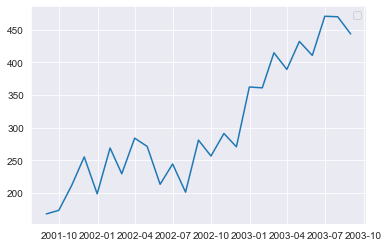

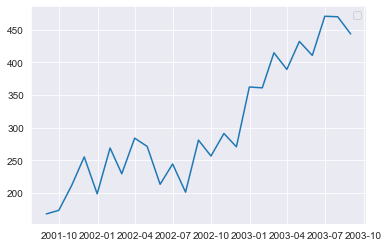

In [49]:
# plot the forecasts
fit_ag.plot_predict()

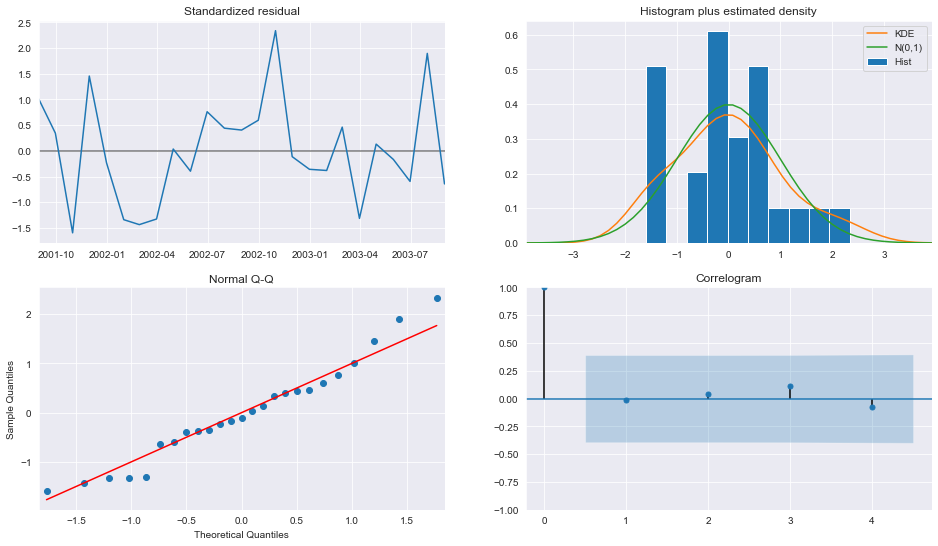

In [47]:
fig = plt.figure(figsize=(16, 9))
fig = fit_ag.plot_diagnostics(fig=fig, lags=4)

In [45]:
# ar_select_order determines the best model
sel = ar_select_order(train, 7, old_names=False)
sel.ar_lags
res = sel.model.fit()
print(res.summary())

                            AutoReg Model Results                             
Dep. Variable:                  Sales   No. Observations:                   32
Model:                     AutoReg(5)   Log Likelihood                -146.845
Method:               Conditional MLE   S.D. of innovations             55.689
Date:                Sat, 05 Feb 2022   AIC                            307.691
Time:                        18:02:02   BIC                            316.762
Sample:                    06-30-2001   HQIC                           310.388
                         - 08-31-2003                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -19.6885     38.458     -0.512      0.609     -95.064      55.687
Sales.L1      -0.2346      0.183     -1.285      0.199      -0.593       0.123
Sales.L2       0.3387      0.175      1.934      0.0

No handles with labels found to put in legend.


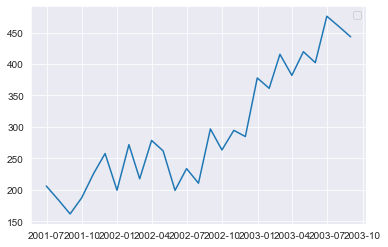

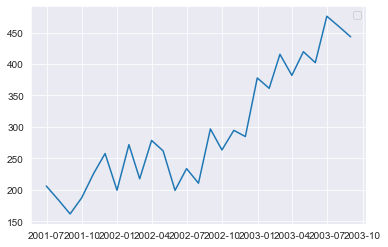

In [46]:
# plot the forecasts
res.plot_predict(4)

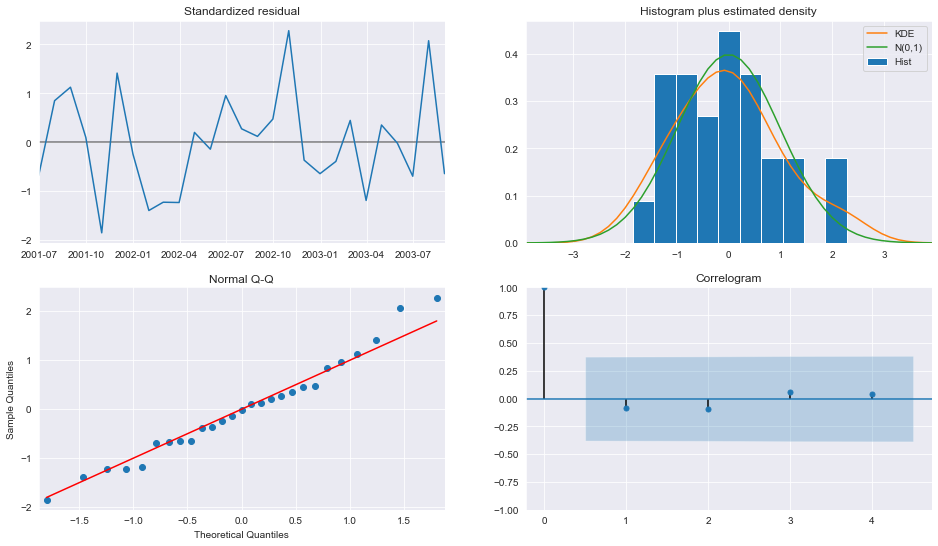

In [50]:
fig = plt.figure(figsize=(16, 9))
fig = res.plot_diagnostics(fig=fig, lags=4)

In [ ]:
# What Is a Moving Average Model? 

What do we use the Moving Average model for?

In time-series, we sometimes observe similarities between past errors and present values. That’s because certain unpredictable events happen, and they need to be accounted for.

In other words, by knowing how far off our estimation yesterday was, compared to the actual value, we can tweak our model, so that it responds accordingly.

So, in this tutorial, we’re going to examine a model that considers past residuals - the Moving Average model. We’ll discuss notation, learn how to interpret it and then digest the different parts. Let’s get right down to it!


In [ ]:
# Miscellous

In [146]:
# create a time series df 
N = 36
numpy.random.seed(N)

dates = pandas.date_range('1/1/2001', periods=N, freq='m')
df = pandas.DataFrame(
    data=numpy.random.randn(N), 
    index=dates,
    columns=['A']
)
